In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.api import layers, models
from sklearn.model_selection import train_test_split

# tf.random.set_seed(1)

from keras.api.metrics import AUC, Precision, Recall
from keras.api.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Sentiment classification

In [3]:
from keras.api.metrics import F1Score
from keras.api.optimizers import Adam


model = models.Sequential()

model.add(layers.Input(shape=(78, 300), name="Input"))

model.add(layers.LSTM(128, name="rnn_ensemble"))

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.2, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.2, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(3, activation='softmax', name="sentiment"))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), AUC(multi_label=True), F1Score(average='weighted')]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_ensemble (LSTM)             │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment (Dense)               │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,051 (1.02 MB)

 Trainable params: 266,451 (1.02 MB)

 Non-trainable params: 600 (2.34 KB)

In [4]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [5]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Sentiment"].isna()]
df_original = df_original.dropna(subset=["Sentiment"])
df_original.info()

df_original["Sentiment"] = df_original["Sentiment"].map({-1: 0, 0: 1, 1: 2})

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              800 non-null    object 
 1   Sentiment         800 non-null    float64
 2   Has opinion       800 non-null    float64
 3   Unnamed: 3        1 non-null      float64
 4   cleaned_text      800 non-null    object 
 5   word_vectors      800 non-null    object 
 6   glove_vectors     800 non-null    object 
 7   fasttext_vectors  800 non-null    object 
dtypes: float64(3), object(5)
memory usage: 56.2+ KB


In [6]:
df_original["Sentiment"].value_counts()

Sentiment
0    470
1    283
2     47
Name: count, dtype: int64

In [7]:
padded_vectors_glove = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors_word2vec = np.load("data/processed/padded_word_2_vec_vectors.npy")
padded_vectors_fasttext = np.load("data/processed/padded_fasttext_vectors.npy")
padded_vectors_glove = padded_vectors_glove[:800]
padded_vectors_word2vec = padded_vectors_word2vec[:800]
padded_vectors_fasttext = padded_vectors_fasttext[:800]

padded_vectors_combined = np.concatenate([padded_vectors_glove, padded_vectors_word2vec, padded_vectors_fasttext], axis=1)

In [8]:
print(f'Glove {padded_vectors_glove[0]}')
print(f'word2vec {padded_vectors_word2vec[0]}')
print(f'fasttext {padded_vectors_fasttext[0]}')

Glove [[ 0.11563   0.3842   -0.16833  ...  0.086759 -0.47894   0.4094  ]
 [ 0.28707   0.15625  -0.22838  ... -0.13257  -0.51496   0.44577 ]
 [-0.36391   0.43771  -0.20447  ... -0.72958  -0.47891   0.72956 ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]
word2vec [[-0.20410156 -0.17382812 -0.22167969 ... -0.09277344 -0.18652344
  -0.00164032]
 [-0.1796875   0.05712891  0.14160156 ...  0.07470703  0.05639648
   0.02209473]
 [-0.06445312 -0.16015625 -0.01208496 ...  0.13671875 -0.02075195
   0.34375   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
fasttext [[-0.11254    0.040199   0.014042  ... -0.0035096  0.12367    0.027518 ]
 [ 0.0070172 -0.081647   0.

In [7]:
padded_vectors_glove.shape

(800, 26, 300)

In [8]:
padded_vectors_combined.shape

(800, 78, 300)

one hot encoding

In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors_combined, df_original["Sentiment"], test_size=0.2, random_state=1, stratify=df_original["Sentiment"])
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [10]:
y_train_encoded.shape

(640, 3)

In [11]:
X_train.shape

(640, 78, 300)

In [12]:
unique_values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 376
1: 226
2: 38


In [13]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 94
1: 57
2: 9


In [14]:
from keras.api.callbacks import EarlyStopping


callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(x=X_train, y=y_train_encoded, epochs=20, callbacks=callback)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3766 - auc: 0.5402 - f1_score: 0.4047 - loss: 1.4697 - precision: 0.3710 - recall: 0.2677
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4666 - auc: 0.5908 - f1_score: 0.4941 - loss: 1.1777 - precision: 0.5275 - recall: 0.3555
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5277 - auc: 0.6487 - f1_score: 0.5493 - loss: 1.0293 - precision: 0.5893 - recall: 0.4264
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6220 - auc: 0.6682 - f1_score: 0.6249 - loss: 0.9605 - precision: 0.6518 - recall: 0.5354
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6392 - auc: 0.7124 - f1_score: 0.6417 - loss: 0.8583 - precision: 0.6940 - recall: 0.5364
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6544 - auc: 0.6996 - f1_score: 0.6477 - loss: 0.8363 - precision: 0.6931 - recall: 0.5909
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7570 

In [15]:
model.save("models/experiments/experiment_3/experiment_3_sentiment_classification_model.keras")

Text(0.5, 0, 'epoch')

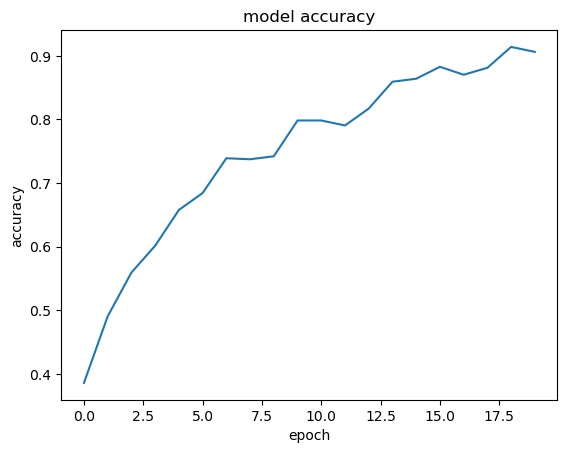

In [16]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

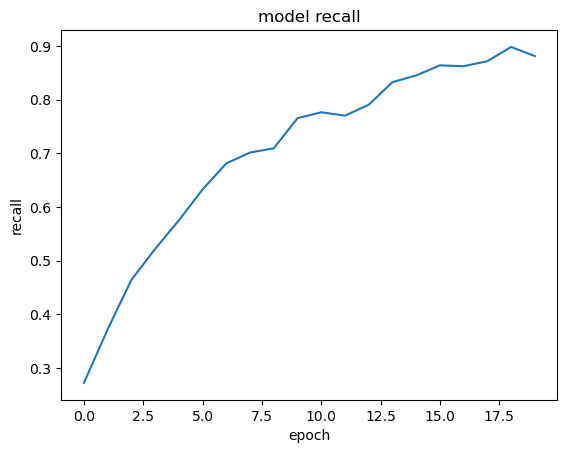

In [17]:
plt.plot(history.history['recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

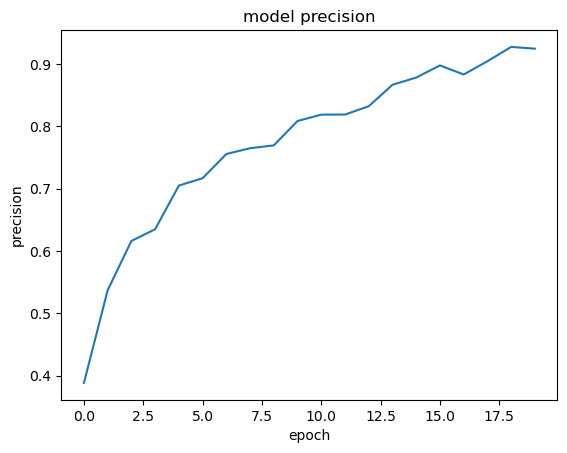

In [18]:
plt.plot(history.history['precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

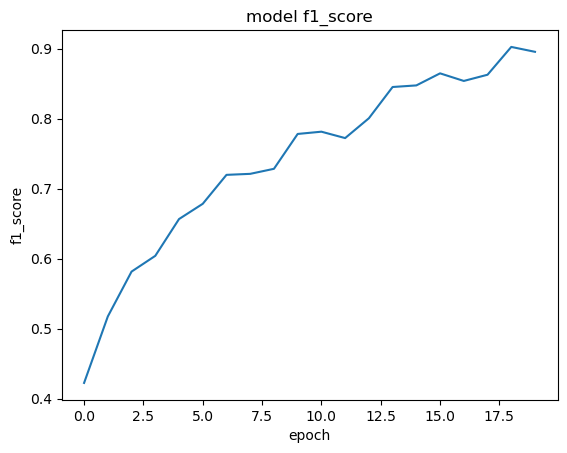

In [19]:
plt.plot(history.history['f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

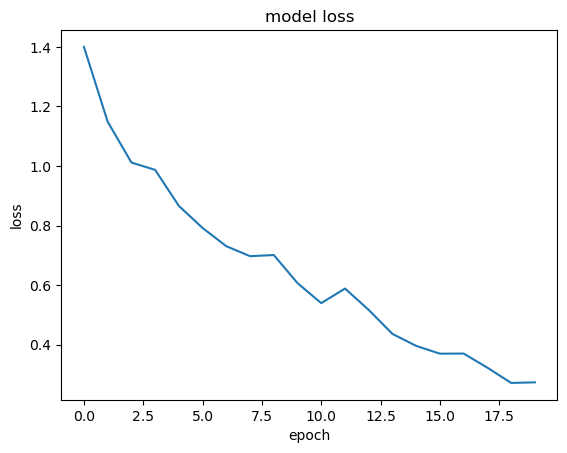

In [20]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [21]:
evaluation = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}, Recall: {evaluation[2]}, Precision: {evaluation[3]}, AUC: {evaluation[4]}, F1-score: {evaluation[5]}')

Loss: 0.8642028570175171, accuracy: 0.637499988079071, Recall: 0.625, Precision: 0.6535947918891907, AUC: 0.666904628276825, F1-score: 0.580290675163269


In [22]:
predictions = model.predict(X_test).argmax(axis=1)
print("Unique values in predictions:", np.unique(predictions))

print("Unique values in y_test:", np.unique(y_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Unique values in predictions: [0 1]
Unique values in y_test: [0 1 2]


[[86  8  0]
 [41 16  0]
 [ 8  1  0]]


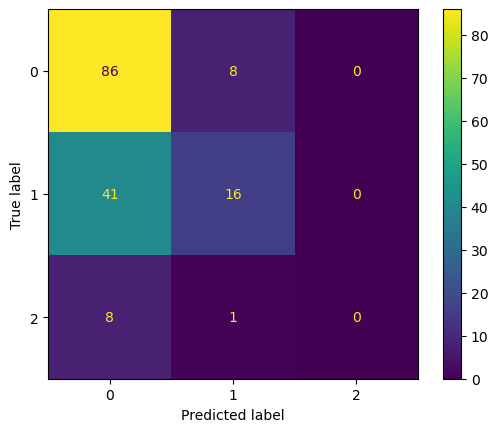

In [23]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)
display = ConfusionMatrixDisplay(matrix)
display.plot()

# Opinion detection

In [24]:
model = models.Sequential()

model.add(layers.Input(shape=(78, 300), name="Domain_1"))

model.add(layers.LSTM(128, name="rnn_ensemble"))

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.2, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.2, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(1, activation='sigmoid', name="opinion"))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision(), AUC(), F1Score(threshold=0.5)],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_ensemble (LSTM)             │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ opinion (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,849 (1.02 MB)

 Trainable params: 266,249 (1.02 MB)

 Non-trainable params: 600 (2.34 KB)

In [25]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [26]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Has opinion"].isna()]
df_original = df_original.dropna(subset=["Has opinion"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              800 non-null    object 
 1   Sentiment         800 non-null    float64
 2   Has opinion       800 non-null    float64
 3   Unnamed: 3        1 non-null      float64
 4   cleaned_text      800 non-null    object 
 5   word_vectors      800 non-null    object 
 6   glove_vectors     800 non-null    object 
 7   fasttext_vectors  800 non-null    object 
dtypes: float64(3), object(5)
memory usage: 56.2+ KB


In [27]:
df_original["Has opinion"].value_counts()

Has opinion
0.0    415
1.0    385
Name: count, dtype: int64

In [28]:
padded_vectors_glove = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors_word2vec = np.load("data/processed/padded_word_2_vec_vectors.npy")
padded_vectors_fasttext = np.load("data/processed/padded_fasttext_vectors.npy")
padded_vectors_glove = padded_vectors_glove[:800]
padded_vectors_word2vec = padded_vectors_word2vec[:800]
padded_vectors_fasttext = padded_vectors_fasttext[:800]

padded_vectors_combined = np.concatenate([padded_vectors_glove, padded_vectors_word2vec, padded_vectors_fasttext], axis=1)

In [29]:
padded_vectors_combined.shape

(800, 78, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors_combined, df_original["Has opinion"], test_size=0.2, random_state=1)

In [31]:
from keras.api.callbacks import EarlyStopping


callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(x=X_train, y=y_train, epochs=25, callbacks=callback)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6011 - auc_1: 0.6409 - f1_score: 0.5469 - loss: 0.7210 - precision_1: 0.5652 - recall_1: 0.5300
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6633 - auc_1: 0.7215 - f1_score: 0.6343 - loss: 0.6401 - precision_1: 0.6468 - recall_1: 0.6239
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7061 - auc_1: 0.7612 - f1_score: 0.6756 - loss: 0.6022 - precision_1: 0.7233 - recall_1: 0.6343
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7332 - auc_1: 0.7931 - f1_score: 0.7303 - loss: 0.5607 - precision_1: 0.7169 - recall_1: 0.7448
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7609 - auc_1: 0.8269 - f1_score: 0.7504 - loss: 0.5381 - precision_1: 0.7804 - recall_1: 0.7234
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7409 - auc_1: 0.8380 - f1_score: 0.7267 - loss: 0.4896 - precision_1: 0.7263 - recall_1: 0.7287
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━

In [32]:
model.save("models/experiments/experiment_3/experiment_3_opinion_detection_model.keras")

Text(0.5, 0, 'epoch')

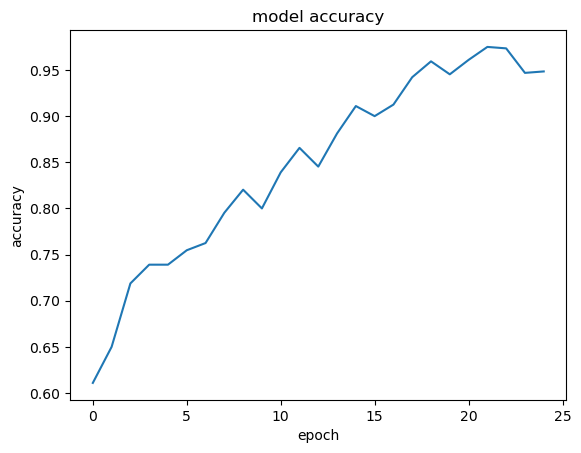

In [33]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

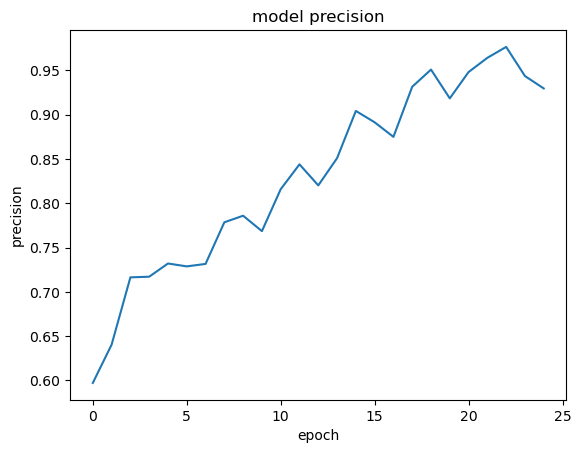

In [34]:
plt.plot(history.history['precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

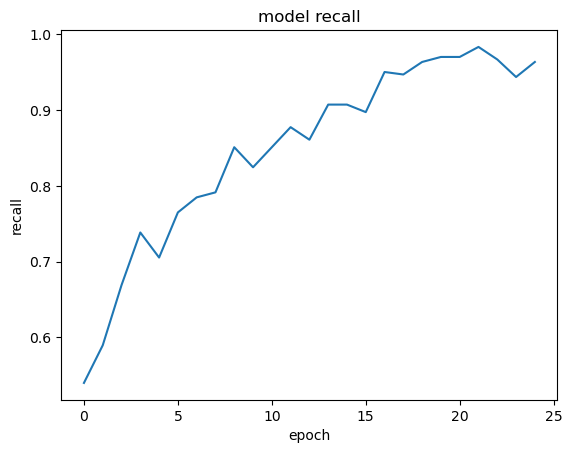

In [35]:
plt.plot(history.history['recall_1'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

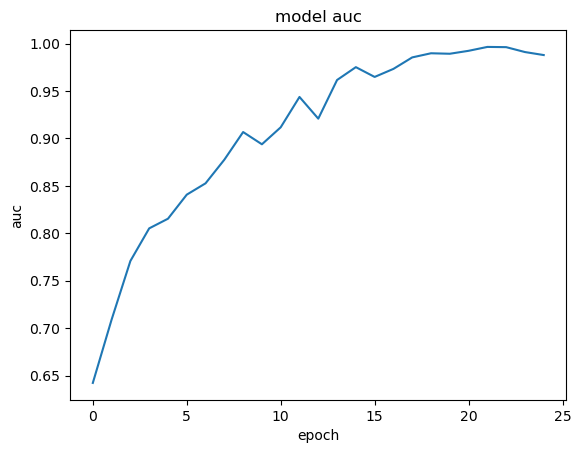

In [36]:
plt.plot(history.history['auc_1'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

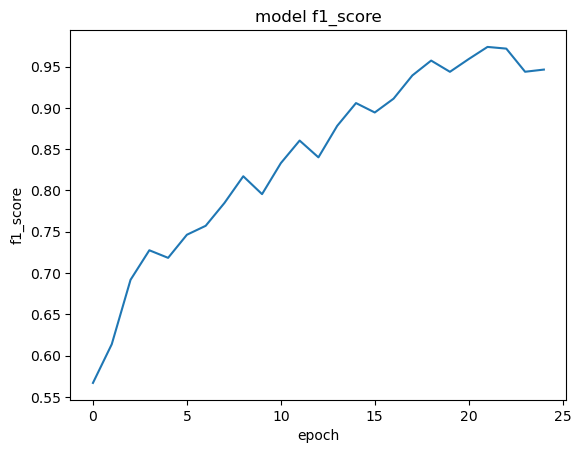

In [37]:
plt.plot(history.history['f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

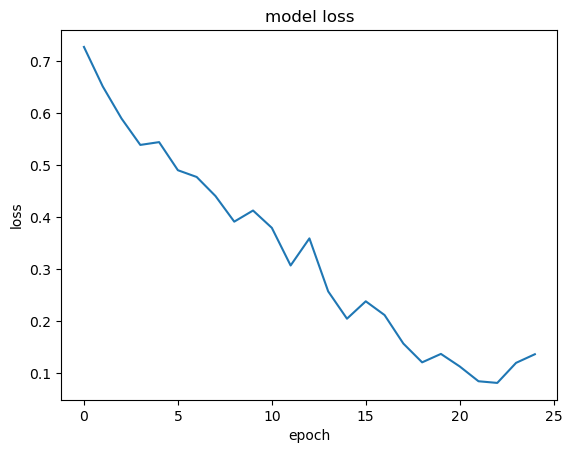

In [38]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [39]:
evaluation = model.evaluate(X_test, y_test)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}, Recall: {evaluation[2]}, Precision: {evaluation[3]}, AUC: {evaluation[4]}, F1_score: {evaluation[5]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5958 - auc_1: 0.6657 - f1_score: 0.6830 - loss: 1.1200 - precision_1: 0.5700 - recall_1: 0.8539
Loss: 1.0672171115875244, accuracy: 0.6312500238418579, Recall: 0.8674699068069458, Precision: 0.6000000238418579, AUC: 0.706853449344635, F1_score: 0.7093595266342163


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


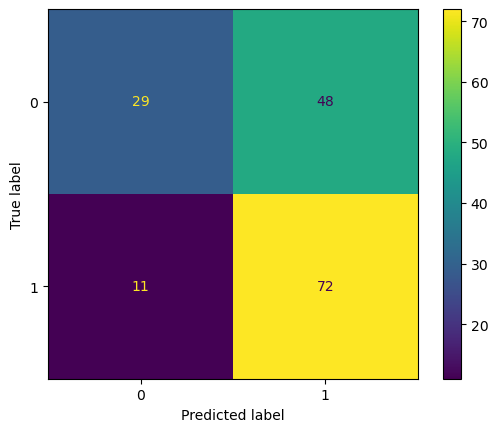

In [40]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(matrix)
display.plot()